In [1]:
% matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import pyarrow as pa   
import pyarrow.parquet as pq
from fastparquet import ParquetFile
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob, Word
from sklearn.externals import joblib
import json

In [2]:
yelp_dir = Path('data', 'yelp')
parquet_dir = yelp_dir / 'parquet'
if not parquet_dir.exists():
    parquet_dir.mkdir(exist_ok=True)

In [3]:
for file in ['review', 'user']:
    print(file)
    json_file = yelp_dir / 'json' / f'yelp_academic_dataset_{file}.json'
    parquet_file = parquet_dir / f'{file}.parquet'

    data = json_file.read_text(encoding='utf-8')
    json_data = '[' + ','.join([l.strip()
                                for l in data.split('\n') if l.strip()]) + ']\n'
    data = json.loads(json_data)
    df = json_normalize(data)
    if file == 'review':
        df.date = pd.to_datetime(df.date)
        latest = df.date.max()
        df['year'] = df.date.dt.year
        df['month'] = df.date.dt.month
        df = df.drop(['date', 'business_id', 'review_id'], axis=1)
    if file == 'user':
        df.yelping_since = pd.to_datetime(df.yelping_since)
        df = (df.assign(member_yrs=lambda x: (latest - x.yelping_since)
                        .dt.days.div(365).astype(int))
              .drop(['elite', 'friends', 'name', 'yelping_since'], axis=1))
    df.dropna(how='all', axis=1).to_parquet(parquet_file, compression='gzip')
    try:
        pd.read_parquet(parquet_file, engine='pyarrow')
    except Exception as e:
        print(e)
        pd.read_parquet(parquet_file, engine='fastparquet')

review
Arrow error: Capacity error: BinaryArray cannot contain more than 2147483646 bytes, have 2147483692
user


In [4]:
user = pd.read_parquet(parquet_dir / 'user.parquet')
review = pd.read_parquet(parquet_dir / 'review.parquet', engine='fastparquet')

In [5]:
user.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,funny,review_count,useful,user_id,member_yrs
0,2.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,lzlZwIpuSWXEnNS91wxjHw,2
1,5.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,XvLBr-9smbI0m_a7dXtB7w,2
2,4.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,QPT4Ud4H5sJVr68yXhoWFw,1
3,4.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,i5YitlHZpf0B3R0s_8NVuw,3
4,3.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,s4FoIXE_LSGviTHBe8dmcg,1


In [6]:
review.head()

,cool,funny,stars,text,useful,user_id,year,month
0,0,0,2,The pizza was okay. Not the best I've had. I p...,0,msQe1u7Z_XuqjGoqhB0J5g,2011,2
1,0,0,5,I love this place! My fiance And I go here atl...,0,msQe1u7Z_XuqjGoqhB0J5g,2012,11
2,1,1,1,Terrible. Dry corn bread. Rib tips were all fa...,3,msQe1u7Z_XuqjGoqhB0J5g,2014,10
3,0,0,2,Back in 2005-2007 this place was my FAVORITE t...,2,msQe1u7Z_XuqjGoqhB0J5g,2011,2
4,0,0,5,Delicious healthy food. The steak is amazing. ...,0,msQe1u7Z_XuqjGoqhB0J5g,2014,9


Merge user dataframe and review dataframe, we use suffix to deal with the same column names.

In [7]:
user_review = (review.merge(user, on='user_id', how='left', suffixes=['', '_user']).drop('user_id', axis=1))

In [8]:
user_review.columns

Index(['cool', 'funny', 'stars', 'text', 'useful', 'year', 'month',
       'average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer',
       'cool_user', 'fans', 'funny_user', 'review_count', 'useful_user',
       'member_yrs'],
      dtype='object')

In [13]:
user_review.stars.describe()

count    5.996996e+06
mean     3.736306e+00
std      1.447924e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: stars, dtype: float64

We will remove zero stars.

In [14]:
user_review = user_review[user_review.stars > 0]

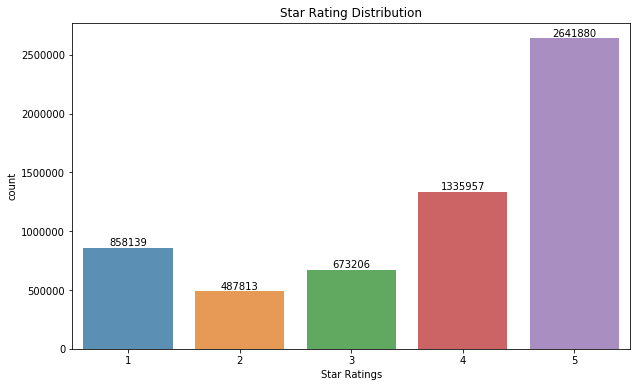

In [25]:
x=user_review['stars'].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('count')
plt.xlabel('Star Ratings')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

Good to know that most of the reviews star ratings are pretty high. And not many terrible reviews. Obvious, there’s an incentive for businesses to solicit as many good reviews as possible.

In [26]:
user_review.stars.value_counts()

5    2641880
4    1335957
1     858139
3     673206
2     487813
Name: stars, dtype: int64

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


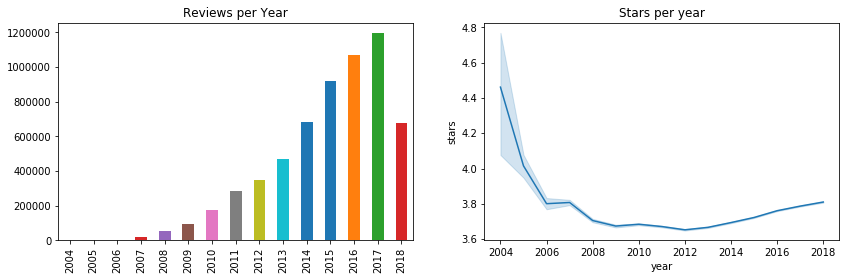

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
user_review.year.value_counts().sort_index().plot.bar(title='Reviews per Year', ax=axes[0]);
sns.lineplot(x='year', y='stars', data=user_review, ax=axes[1])
axes[1].set_title('Stars per year');

In [28]:
user_review.member_yrs.value_counts()

5     789312
6     767460
4     753483
7     750720
3     747215
2     607776
8     484111
1     336847
9     326262
10    170026
0     159440
11     78357
12     21801
13      4185
Name: member_yrs, dtype: int64

There are over 4,000 members have been a Yelp member as long as it was founded.

In [29]:
user_review.head(3)

,cool,funny,stars,text,useful,year,month,average_stars,compliment_cool,compliment_cute,...,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool_user,fans,funny_user,review_count,useful_user,member_yrs
0,0,0,2,The pizza was okay. Not the best I've had. I p...,0,2011,2,3.31,2,0,...,0,0,0,0,1,1,1,11,4,7
1,0,0,5,I love this place! My fiance And I go here atl...,0,2012,11,3.31,2,0,...,0,0,0,0,1,1,1,11,4,7
2,1,1,1,Terrible. Dry corn bread. Rib tips were all fa...,3,2014,10,3.31,2,0,...,0,0,0,0,1,1,1,11,4,7


Let's have a look a review sample.

In [34]:
review_sample = user_review.text.sample(1).iloc[0]
print(review_sample)

We went here because we saw on social media that they had a vegan burger. Well, that wasn't the case. We got the veggie sandwich. The service was ok. Then while we were eating, the sterateck auditor came in. It was disappointing to see the entire staff scramble and start putting on gloves and stuff they should always be doing. Not sure I will return here. Standards should be upheld at all times, not when the inspector shows up.


Let's check the polarity of this review sample. Polarity ranges from -1 (most negative) to 1 (most positive).

In [59]:
TextBlob(review_sample).sentiment

Sentiment(polarity=-0.06333333333333332, subjectivity=0.5561111111111111)

The above review has a polarity of about -0.06, meaning it is slightly negative, and a subjectivity of about 0.56, meaning it is fairly subjective.

To proceed faster, we will sample 1 million reviews from our current data. And add a new column for polarity.

In [37]:
sample_reviews = user_review[['stars', 'text']].sample(1000000)

Define a function that accepts text and return the polarity.

In [40]:
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

In [41]:
sample_reviews['polarity'] = sample_reviews.text.apply(detect_polarity)
sample_reviews.head()

,stars,text,polarity
3832255,4,Love love love my neighborhood Sprouts! Everyb...,0.525000
5979201,4,"Als Liebhaber der deep dish Pizzas, welche urs...",0.125000
33378,5,Always good food and if you buy a burrito toda...,0.453571
1888280,4,Brussel Sprouts... I'm gonna base my review on...,0.160114
1507759,4,"On a rainy and wet day, the weather was even i...",0.267622


First several rows look good, stars and polarity are in line with each other, means the higher the star, the higher the polarity, as it should be. 

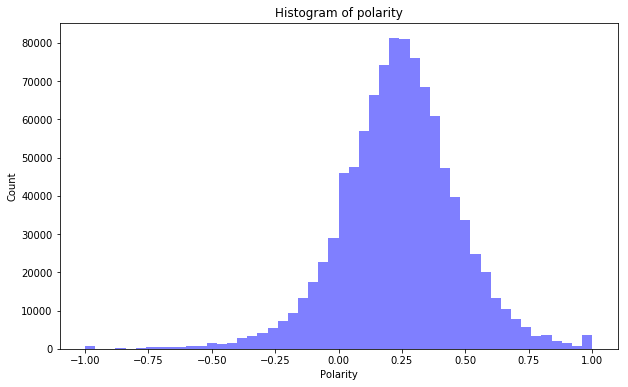

In [56]:
# A histogram of the polarity scores.
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(sample_reviews.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

Most polarity scores are above 0, means most of them are postive sentiment, this is in line with the star distribution. 

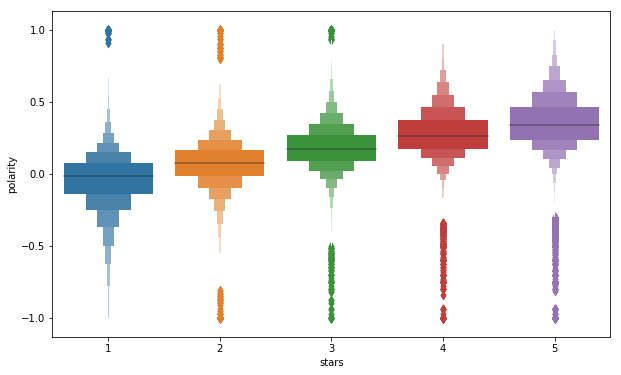

In [44]:
# Box plot of sentiment grouped by stars
plt.figure(figsize=(10,6))
sns.boxenplot(x='stars', y='polarity', data=sample_reviews)
plt.show();

In general, this is as good as we'd expect. Let's investigate deeper and see whether we can find anything interesting or outlier.

In [45]:
pd.set_option('max_colwidth', 400)

Reviews that have the lowest polarity:

In [57]:
sample_reviews[sample_reviews.polarity == -1].text.head()

676402                                                                                              Awful quality with awful staff. 9 of us had stomach upset after having lunch buffet.
5721798                                                                                                                        worst internet ever, i have to use my phone data at home!
2992269    Horrible customer service! Waited at the front desk for 30 mins no one came and asked me if I needed anything or if I was already being assisted. Never come here EVER again.
1274473                                                                                                         I can't stand Ghazale.  Worst falafel ever. They microwave your falafel.
1307440                                              Needed my car towed from my house to a garage that was 2 miles\naway. The cost of the tow was $145.00. Completly outrageous price!!
Name: text, dtype: object

Reviews that have the lowest stars:

In [58]:
sample_reviews[sample_reviews.stars == 1].text.head()

4385486                                                                                                                                                 Do not use this company... Crappy customer service and not friendly staff... Call center staff the same.. Call Monday and didn't get service until today Wednesday . I am not using anymore... They are bad bad bad... They are contracted by AHS.. Called AHS TOO
343256                                                                     We tried Swerve because we purchased a Groupon.  Our server was very nice but our food didn't come out to us for 45 minutes. Out of 14 tables only three were being used. We kept asking when we would receive our salad and burger and keep being given the answer "two more minutes". Once our food did come out the burger was unimpressive.
4242301    First and probably only visit. We ordered a Salted Caramel Latte, Cappuccino, Affogato and Squid Rings.\n\nNo latte art here, too much milk foam, and espresso was very

Reviews that have lowest polarity (most negative sentiment) but with a 5-star:

In [51]:
sample_reviews[(sample_reviews.stars == 5) & (sample_reviews.polarity == -1)].head(10)

,stars,text,polarity
5630685,5,The stuffing I just administered to myself was thorough and devastating. But I'll assault myself again here in identical fashion when the opportunity presents itself. Our waiter knew what I needed and provided recommendations tailored to my gluttonous yet vegetarian needs. All of the stars.,-1.0
3175756,5,"Bueno, alguien tiene que hacer una review en español. Al menos voy a hacer de la noche (no fui al day club)\nEl boliche explota. Está 10 puntos y tenés un sector abierto (el patio) donde pasan mas hip hop , y es más tranqui para charlar y conocer gente. Asi mismo está el sector de adentro, donde toca el Dj, que en nuestro caso fue Porter Robinson. Ahí adentro casi no se puede estar de lo lleno...",-1.0
5296058,5,One thing to say Bloody Mary Bar off the charts!,-1.0
4350889,5,PBJ and Bacon burger is heaven sent!!!! No Joke! Don't be afraid because it sounds funky... it is DELISH!!!!!,-1.0
4754984,5,"I'm that annoying customer with food allergies and restrictions, but Peter was so patient and helpful!!! Made me feel welcomed and told me all my options... Thank you Peter!",-1.0
5146895,5,I've overheard the worst thing about this bar is the font size on the bill.....it's all about size people.,-1.0
3209896,5,"Un petit bijou du Mile-Ex, le marché Soupson vaut absolument le détour. C'est à la fois un petit marché hétéroclite où on peut acheter bière, bonbon, grignotines et fruits/légumes (attention, les prix sont plus élevés qu'ailleurs) et un comptoir à sandwiches et à soupes parfait pour le lunch.\n\nLes soupes sont fabuleusement incroyables, je ne comprends pas comment la sympathique propriétaire ...",-1.0
5519806,5,"Threw on my flowmasters and couldn't be fucking happier, transformed my cars exhaust system into a beast!!!",-1.0
4425019,5,"In the midst of a horrible night, my girlfriend and I stopped in at around 1 AM. The proprieter of the bar and the clientele were so caring and welcoming that it saved our evening from despair. Thank you thank you thank you.",-1.0
3852388,5,chicken!\nwaffles!\nkool aid!\n\nwhy aren't you eating at lolo's yet?,-1.0


Reviews that have the highest polarity (most positive sentiment) but with a 1-star:

In [54]:
sample_reviews[(sample_reviews.stars == 1) & (sample_reviews.polarity == 1)].head(10)

,stars,text,polarity
4307505,1,"Discount Tire treated me like they were doing me a favor and may have a 4 hour wait, no promises, and some mumbo jumbo about additional road hazard expense, so I went to Costco. In and out in an hour with excellent pricing at Costco. Awesome!",1.0
5819703,1,$2.71 for a bottle of water...horrible!!! 16.9 ounces of Nestle. Gimme a fffff break! Not even good quality alkaline water! Get outta here!!!!,1.0
3751568,1,"Sahara was perfect when I had the college student's budget. But I'll never stay here again, I don't even think I want to even walk in here again. All the rooms smell like smoke even if it's a non-smoking room and the linens look like they're been there since the hotel has opened.",1.0
227044,1,"Problem is that they use ""take a number"" system, then let locals cut in line. I waited my turn for 3o minutes while people were allowed to cut. Cavatelli was so so at best.",1.0
5922719,1,"They have made so many mistakes here, They must have underaged teenagers running the accounting deptartment!\nGet it together!!!!!!!!!!!",1.0
2129917,1,Aweful the lack of cheese is one thing but where was the meat...?!??!?!no cilantro drizzle or anything would rather have anything else but the beer is awesome! !!!!!!!!,1.0
4268651,1,"Q=Quite\nU=Unsanitary\nA=And\nD=Dumpy\n\nA great location, however!",1.0
156915,1,"I bought once from this guy Jerry, and had an excellent experience with him and their products. But when I called to have him bring me some steaks again, Jerry had his arrogant boss with him who is Fat and bald (just like myself lol) this boss insulted me to the max by mentioning my departed Son who was an army medic. To the management, please do not let this SOB be associated with your busine...",1.0
348113,1,"Visited this location yesterday 5/16, I ordered a tuna lettuce wrap with the works. When lunch time rolls around, I take a healthy bite of my wrap and what do I find??? NO TUNA!!!!",1.0
5645590,1,"Just called to find if they have a product in stock, the guy on the phone was complaining about not hearing me well, before I had a chance to improve my reception he just hanged up on me! What a great way to deal with customers !",1.0


TextBlob goes along finding words and phrases it can assign polarity and subjectivity to, and it averages them all together for longer text, such as our Yelp reviews. Want to learn how TextBlob calculates polarity and subjectivity, this article from Aaron has given a simple but clear explanation. https://planspace.org/20150607-textblob_sentiment/